In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tensorflow_datasets as tfds

print(tf.__version__)

2.5.0


In [2]:
data = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
def translate(num):
    return data[num]

In [3]:
#IMPORTAÇÃO E NORRMALIZAÇÃO
(x_train, y_train), (x_test,y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype(float)/255
x_test = x_test.astype(float)/255

#CRIAR DATASET
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

170500096/170498071 [==============================] - 4s 0us/step


(10000, 32, 32, 3)


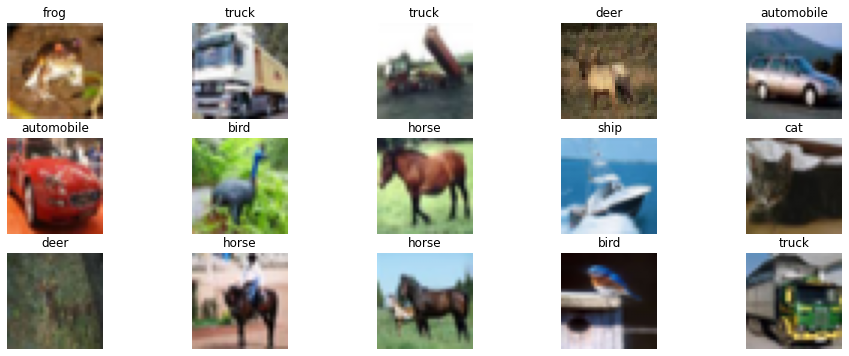

In [6]:
#cifar = tf.keras.datasets.cifar10
#(x_train, y_train), (x_test, y_test) = cifar.load_data()
print(x_test.shape)

cols = 5
rows = 3

fig, axies = plt.subplots(rows, cols, figsize=(16, 6))

for i in range(rows):
    for j in range(cols):
        axies[i][j].set_title(translate(y_train[i*cols + j][0]))
        axies[i][j].axis('Off')
        axies[i][j].imshow(x_train[i*cols + j])

In [7]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [8]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    figure(figsize=(10, 7), dpi=80)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm[:,0])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# alpha = 0 -> No prune

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_accuracy = tf.keras.metrics.Accuracy()
test_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_accuracy = tf.keras.metrics.Accuracy()

In [ ]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),
     
        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu'),   
        keras.layers.Conv2D(64, (3, 3),name="conv2", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),
        keras.layers.Conv2D(128, (3, 3),name="conv3", activation='relu'),
        keras.layers.Conv2D(128, (3, 3),name="conv4", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),
     
        keras.layers.Flatten(name = "flatten"),
     
        keras.layers.Dense(256, name="dense1", activation='relu'),
        keras.layers.Dense(128, name="dense2", activation='relu'),
        keras.layers.Dense(10, name="dense3")
    ],
    name="modelo-0.0",
)
model.summary()

Model: "modelo-0.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (64, 30, 30, 32)          896       
_________________________________________________________________
conv2 (Conv2D)               (64, 28, 28, 64)          18496     
_________________________________________________________________
mp1 (MaxPooling2D)           (64, 14, 14, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (64, 12, 12, 128)         73856     
_________________________________________________________________
conv4 (Conv2D)               (64, 10, 10, 128)         147584    
_________________________________________________________________
mp2 (MaxPooling2D)           (64, 5, 5, 128)           0         
_________________________________________________________________
flatten (Flatten)            (64, 3200)                0

In [ ]:
epochs = 30
alpha = 0.0
np.set_printoptions(threshold=np.inf)


model_sparsity = np.array([])

model_sparsity_layers = np.array([])

model_train_loss = np.array([])
model_train_acc = np.array([])

model_test_loss = np.array([])
model_test_acc = np.array([])
sparsity = 0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    # Iterate over the batches of the dataset.
    acc_epoch_mean = np.array([])
    loss_epoch_mean = np.array([])

    acct_epoch_mean = np.array([])
    losst_epoch_mean = np.array([])
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
      #sparsity_batch = np.array([])
      #Verify if the model needs to be pruned
      n_zeros = 0
      size = 0
      
      if alpha > 0:
        for layer_weights in model.trainable_variables:
          #flatten weights
          f_weights = tf.reshape(layer_weights,[-1])

          #get standard deviation of each layer
          lim = alpha*tf.math.reduce_std(f_weights)

          #create a mask
          mask = tf.cast(tf.where(tf.abs(layer_weights)>lim,1,0), tf.float32)

          #assign pruned weights to the layer
          layer_weights.assign(tf.math.multiply(layer_weights,mask))

          #check sparsity
          flat_array = np.array((tf.reshape(mask,[-1])))
          n_zeros += np.count_nonzero(np.array(flat_array) == 0)
          
          #n_zeros = np.count_nonzero(m)
          size += flat_array.shape[0]

          #print(size)
          #print(n_zeros)
          sparsity = n_zeros*100/size


      with tf.GradientTape() as tape:
        pred = model(x_batch_train, training=True)
        loss = loss_fn(y_batch_train, pred)
        
      grads = tape.gradient(loss, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      #acc = acc_metric(y_batch_train, pred)
      predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
      acc = train_accuracy(y_batch_train, predictions)

      acc_epoch_mean = np.append(acc_epoch_mean, acc)
      loss_epoch_mean = np.append(loss_epoch_mean, loss)


      if step % 50 == 0:
        print("So far", step, "m_batches ->","train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity)
        #print("train loss = ",float(loss), "train accuracy = ", float(acc*100), "sparsity = ", sparsity)

      if step == 781:
        print("Last train values over the epoch:", epoch)
        print("So far", step, "m_batches ->","train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity,"\n")


    #Test
    for step, (x_batch_test, y_batch_test) in enumerate(test_ds):
      test_pred = model(x_batch_test, training=False)
      test_loss = loss_fn(y_batch_test,test_pred)
      test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
      test_acc = test_accuracy(y_batch_test, test_prediction)

      acct_epoch_mean = np.append(acc_epoch_mean, test_acc)
      losst_epoch_mean = np.append(loss_epoch_mean, test_loss)
      if step == 156:
        print("\nLast train values over the epoch:", epoch)
        print("train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity,"\n")
      
    #acc = acca(y_batch_train, pred)
    #if step % 100 == 0:
    #  print("loss = ",float(loss), "accuracy = ", float(acc*100))
    
    print("test loss =",float(test_loss), "test accuracy =", float(test_acc*100))

    #model_test_acc = np.append(model_test_acc, test_acc*100)
    #model_test_loss = np.append(model_test_loss,test_loss)

    #save mean results on lists
    model_test_acc = np.append(model_test_acc, np.mean(acct_epoch_mean)*100)
    model_test_loss = np.append(model_test_loss,np.mean(losst_epoch_mean)*100)

    model_sparsity = np.append(model_sparsity,sparsity)

    model_train_acc = np.append(model_train_acc, np.mean(acc_epoch_mean))
    model_train_loss = np.append(model_train_loss,np.mean(loss_epoch_mean))



Start of epoch 0
So far 0 m_batches -> train loss = 2.3084359169006348 train acc = 6.25 sparsity = 0
So far 50 m_batches -> train loss = 1.913266897201538 train acc = 19.02573585510254 sparsity = 0
So far 100 m_batches -> train loss = 2.067458152770996 train acc = 24.25742530822754 sparsity = 0
So far 150 m_batches -> train loss = 1.7542192935943604 train acc = 27.317882537841797 sparsity = 0
So far 200 m_batches -> train loss = 1.4764677286148071 train acc = 29.819652557373047 sparsity = 0
So far 250 m_batches -> train loss = 1.6299827098846436 train acc = 32.48879623413086 sparsity = 0
So far 300 m_batches -> train loss = 1.4991858005523682 train acc = 34.47882080078125 sparsity = 0
So far 350 m_batches -> train loss = 1.22103750705719 train acc = 36.31588363647461 sparsity = 0
So far 400 m_batches -> train loss = 1.3610587120056152 train acc = 37.951995849609375 sparsity = 0
So far 450 m_batches -> train loss = 1.3077073097229004 train acc = 39.4539909362793 sparsity = 0
So far 500

In [ ]:
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(x_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, y_test)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 75.300%


Confusion matrix, without normalization
[[798  17  51  22  16   2  17   8  44  25]
 [ 20 881   7   8   2   5  12   1  23  41]
 [ 50   5 631  52  93  56  69  32   8   4]
 [ 22   9  74 532  80 133  80  45   9  16]
 [ 18   2  53  40 763  18  58  39   5   4]
 [  8   2  49 144  77 631  35  41   2  11]
 [  3   2  30  46  31  19 854   8   5   2]
 [ 19   1  29  29  76  43  17 773   4   9]
 [ 67  29   9  12   3   6  10   7 832  25]
 [ 30  60   9  14  10   6   7  10  19 835]]


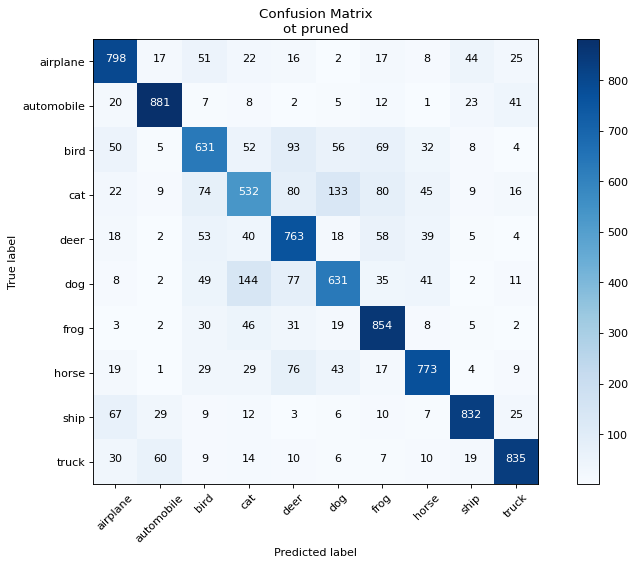

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=prediction)
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix\not pruned')

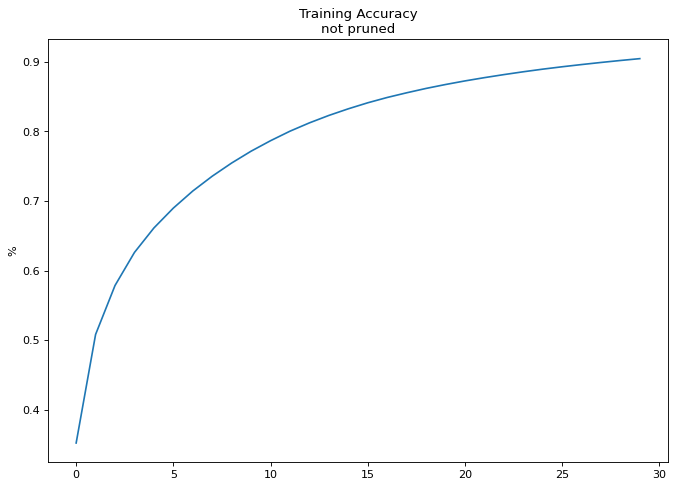

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_train_acc)
plt.title('Training Accuracy\nnot pruned')
plt.ylabel('%')
plt.show()

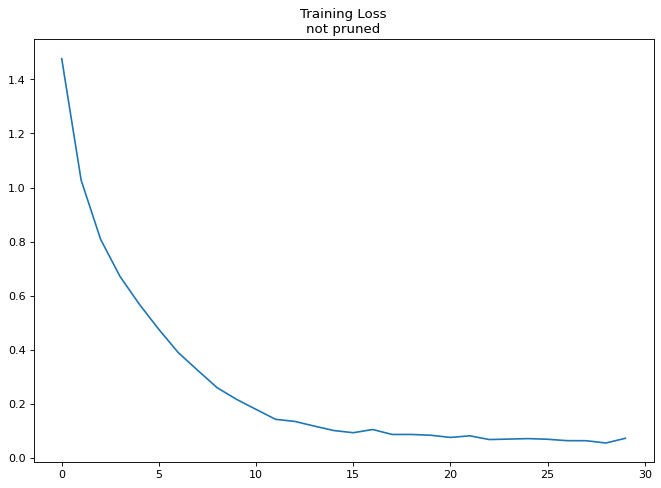

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_train_loss)
plt.title('Training Loss\nnot pruned')
plt.show()

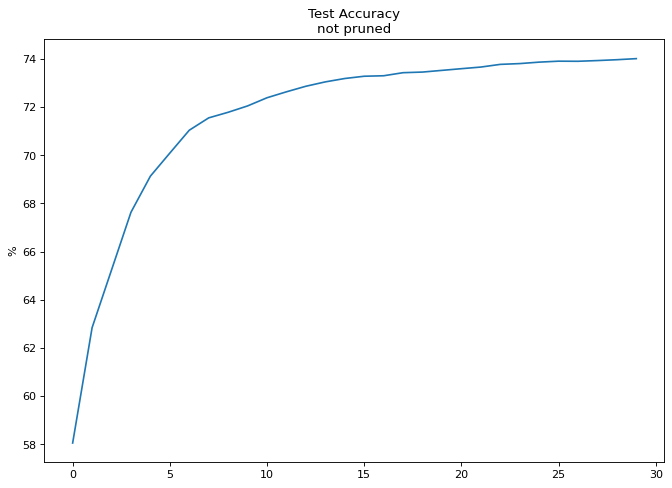

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_test_acc)
plt.title('Test Accuracy\nnot pruned')
plt.ylabel('%')
plt.show()

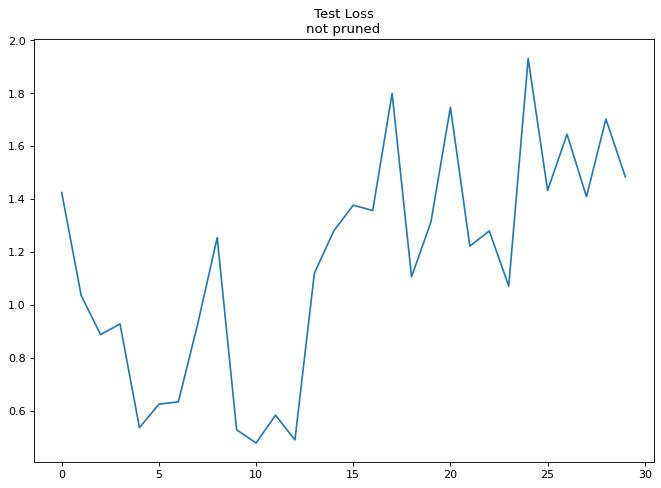

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_test_loss)
plt.title('Test Loss\nnot pruned')
plt.show()

In [ ]:
plt.plot(model_sparsity)
plt.title('Model Sparsity\nnot pruned')
figure(figsize=(20, 15), dpi=80)
plt.ylabel('%')
plt.show()

In [ ]:
accuracies = np.array([])
losses = np.array([])
spar = np.array([])

In [ ]:
accuracies = np.append(accuracies,model_train_acc, axis=0)
losses = np.append(losses,model_train_losse, axis=0)
spar = np.append(spar,model_sparsity,axis=0)

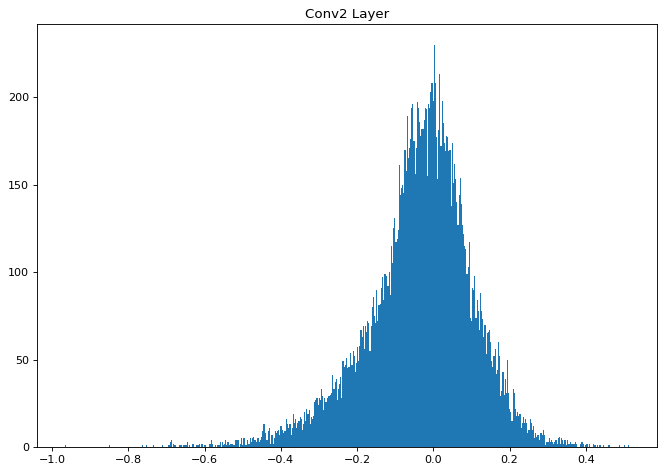

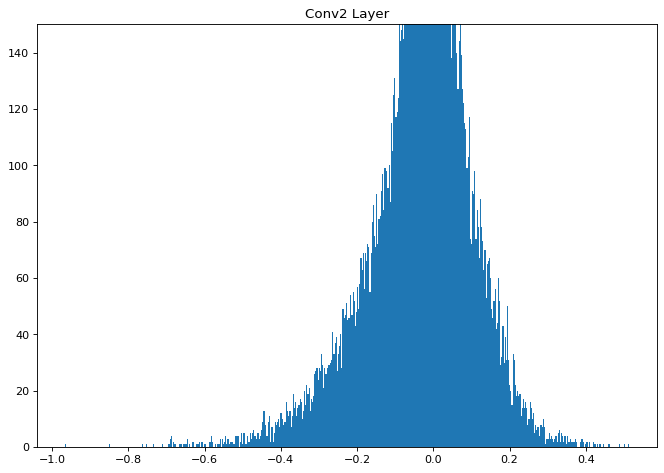

In [ ]:
for layer in model.layers:
  if layer.name == "conv2":
    a = tf.reshape(layer.weights[0],[-1])
    #print(a.shape)
    figure(figsize=(10, 7), dpi=80)
    plt.title('Conv2 Layer')
    plt.hist(a,500)
    plt.show()

    print("\n")
    figure(figsize=(10, 7), dpi=80)
    plt.title('Conv2 Layer')
    plt.hist(a,500)
    plt.ylim((0,150))
    plt.show()

In [ ]:
#salvar status
np.savetxt("acc_train0.csv",model_train_acc,delimiter=",")
np.savetxt("loss_train0.csv",model_train_loss,delimiter=",")
np.savetxt("sparsity0.csv",model_sparsity,delimiter=",")

In [ ]:
#salvar modelo
!mkdir -p saved_model
model.save('model/model00')
!zip -r models.zip model/

INFO:tensorflow:Assets written to: model/model00/assets
  adding: model/ (stored 0%)
  adding: model/model00/ (stored 0%)
  adding: model/model00/saved_model.pb (deflated 89%)
  adding: model/model00/variables/ (stored 0%)
  adding: model/model00/variables/variables.index (deflated 58%)
  adding: model/model00/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model/model00/assets/ (stored 0%)
  adding: model/model00/keras_metadata.pb (deflated 93%)


# alpha = 0.25

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_accuracy = tf.keras.metrics.Accuracy()
test_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_accuracy = tf.keras.metrics.Accuracy()

In [ ]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),
     
        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu'),   
        keras.layers.Conv2D(64, (3, 3),name="conv2", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),
        keras.layers.Conv2D(128, (3, 3),name="conv3", activation='relu'),
        keras.layers.Conv2D(128, (3, 3),name="conv4", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),
     
        keras.layers.Flatten(name = "flatten"),
     
        keras.layers.Dense(256, name="dense1", activation='relu'),
        keras.layers.Dense(128, name="dense2", activation='relu'),
        keras.layers.Dense(10, name="dense3")
    ],
    name="modelo-0.25",
)
model.summary()

Model: "modelo-0.25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (64, 30, 30, 32)          896       
_________________________________________________________________
conv2 (Conv2D)               (64, 28, 28, 64)          18496     
_________________________________________________________________
mp1 (MaxPooling2D)           (64, 14, 14, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (64, 12, 12, 128)         73856     
_________________________________________________________________
conv4 (Conv2D)               (64, 10, 10, 128)         147584    
_________________________________________________________________
mp2 (MaxPooling2D)           (64, 5, 5, 128)           0         
_________________________________________________________________
flatten (Flatten)            (64, 3200)                

In [ ]:
epochs = 30
alpha = 0.25
np.set_printoptions(threshold=np.inf)


model_sparsity = np.array([])

model_sparsity_layers = np.array([])

model_train_loss = np.array([])
model_train_acc = np.array([])

model_test_loss = np.array([])
model_test_acc = np.array([])
sparsity = 0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    # Iterate over the batches of the dataset.
    acc_epoch_mean = np.array([])
    loss_epoch_mean = np.array([])

    acct_epoch_mean = np.array([])
    losst_epoch_mean = np.array([])
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
      #sparsity_batch = np.array([])
      #Verify if the model needs to be pruned
      n_zeros = 0
      size = 0
      
      if alpha > 0:
        for layer_weights in model.trainable_variables:
          #flatten weights
          f_weights = tf.reshape(layer_weights,[-1])

          #get standard deviation of each layer
          lim = alpha*tf.math.reduce_std(f_weights)

          #create a mask
          mask = tf.cast(tf.where(tf.abs(layer_weights)>lim,1,0), tf.float32)

          #assign pruned weights to the layer
          layer_weights.assign(tf.math.multiply(layer_weights,mask))

          #check sparsity
          flat_array = np.array((tf.reshape(mask,[-1])))
          n_zeros += np.count_nonzero(np.array(flat_array) == 0)
          
          #n_zeros = np.count_nonzero(m)
          size += flat_array.shape[0]

          #print(size)
          #print(n_zeros)
          sparsity = n_zeros*100/size


      with tf.GradientTape() as tape:
        pred = model(x_batch_train, training=True)
        loss = loss_fn(y_batch_train, pred)
        
      grads = tape.gradient(loss, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      #acc = acc_metric(y_batch_train, pred)
      predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
      acc = train_accuracy(y_batch_train, predictions)

      acc_epoch_mean = np.append(acc_epoch_mean, acc)
      loss_epoch_mean = np.append(loss_epoch_mean, loss)


      if step % 50 == 0:
        print("So far", step, "m_batches ->","train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity)
        #print("train loss = ",float(loss), "train accuracy = ", float(acc*100), "sparsity = ", sparsity)

      if step == 781:
        print("Last train values over the epoch:", epoch)
        print("So far", step, "m_batches ->","train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity,"\n")


    #Test
    for step, (x_batch_test, y_batch_test) in enumerate(test_ds):
      test_pred = model(x_batch_test, training=False)
      test_loss = loss_fn(y_batch_test,test_pred)
      test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
      test_acc = test_accuracy(y_batch_test, test_prediction)

      acct_epoch_mean = np.append(acct_epoch_mean, test_acc)
      losst_epoch_mean = np.append(losst_epoch_mean, test_loss)
      if step == 156:
        print("\nLast train values over the epoch:", epoch)
        print("train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity,"\n")
      
    #acc = acca(y_batch_train, pred)
    #if step % 100 == 0:
    #  print("loss = ",float(loss), "accuracy = ", float(acc*100))
    
    print("test loss =",float(test_loss), "test accuracy =", float(test_acc*100))

    #model_test_acc = np.append(model_test_acc, test_acc*100)
    #model_test_loss = np.append(model_test_loss,test_loss)

    #save mean results on lists
    model_test_acc = np.append(model_test_acc, np.mean(acct_epoch_mean)*100)
    model_test_loss = np.append(model_test_loss,np.mean(losst_epoch_mean))

    model_sparsity = np.append(model_sparsity,sparsity)

    model_train_acc = np.append(model_train_acc, np.mean(acc_epoch_mean)*100)
    model_train_loss = np.append(model_train_loss,np.mean(loss_epoch_mean))
    




Start of epoch 0
So far 0 m_batches -> train loss = 2.3127453327178955 train acc = 3.125 sparsity = 14.516562293850745
So far 50 m_batches -> train loss = 2.0105385780334473 train acc = 15.59436321258545 sparsity = 20.270833295263294
So far 100 m_batches -> train loss = 1.846178412437439 train acc = 21.859529495239258 sparsity = 22.05059233933378
So far 150 m_batches -> train loss = 1.887414574623108 train acc = 26.045116424560547 sparsity = 23.224763676432698
So far 200 m_batches -> train loss = 1.5386488437652588 train acc = 29.18998908996582 sparsity = 24.3121353271069
So far 250 m_batches -> train loss = 1.724305272102356 train acc = 31.212648391723633 sparsity = 25.29388546461588
So far 300 m_batches -> train loss = 1.5394309759140015 train acc = 33.49771499633789 sparsity = 26.095183622452428
So far 350 m_batches -> train loss = 1.400250792503357 train acc = 35.14957046508789 sparsity = 26.75138925182325
So far 400 m_batches -> train loss = 1.4581706523895264 train acc = 36.6622

In [ ]:
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(x_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, y_test)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 73.250%


Confusion matrix, without normalization
[788  26  76  24  14   9   7  11  55  38]


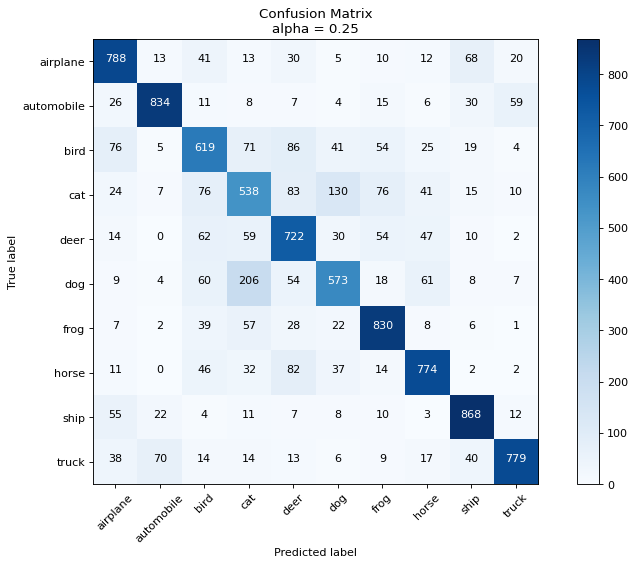

In [ ]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
cm = confusion_matrix(y_true=y_test, y_pred=prediction)
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix\nalpha = 0.25')

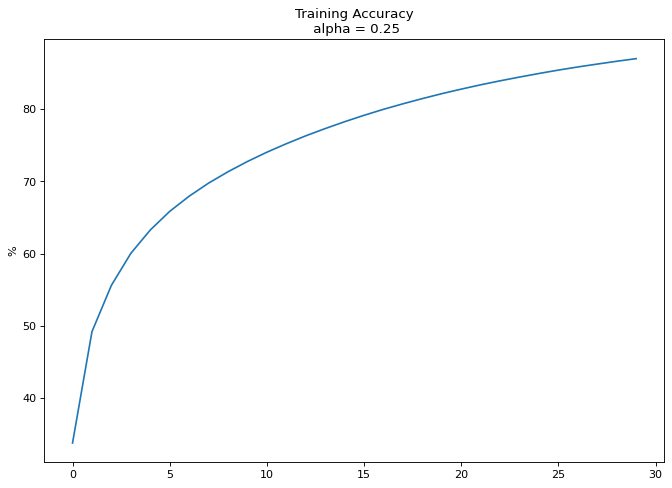

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_train_acc)
plt.title('Training Accuracy\n alpha = 0.25')
plt.ylabel('%')
plt.show()

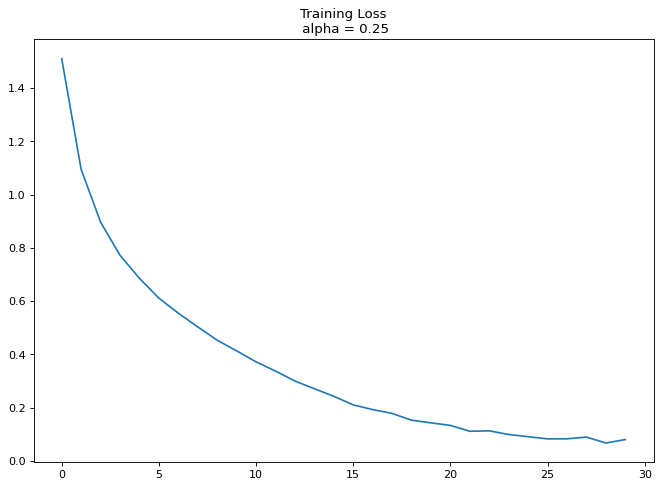

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_train_loss)
plt.title('Training Loss\n alpha = 0.25')
plt.show()

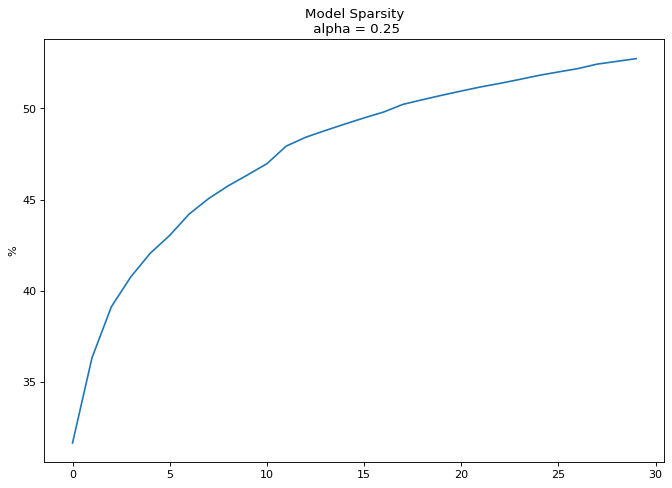

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_sparsity)
plt.title('Model Sparsity\n alpha = 0.25')
plt.ylabel('%')
plt.show()

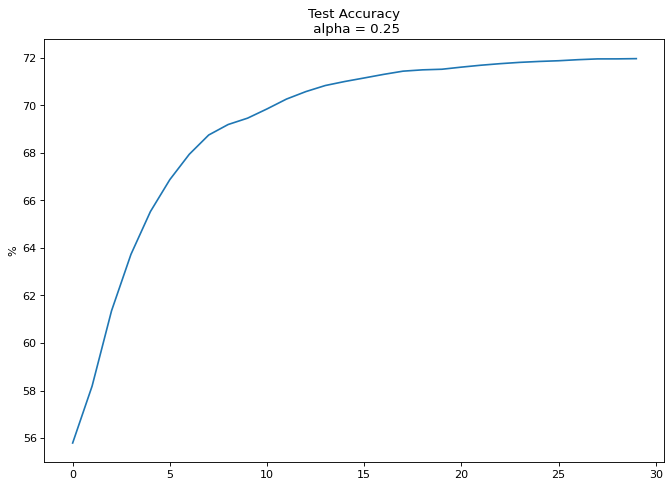

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_test_acc)
plt.title('Test Accuracy\n alpha = 0.25')
plt.ylabel('%')
plt.show()

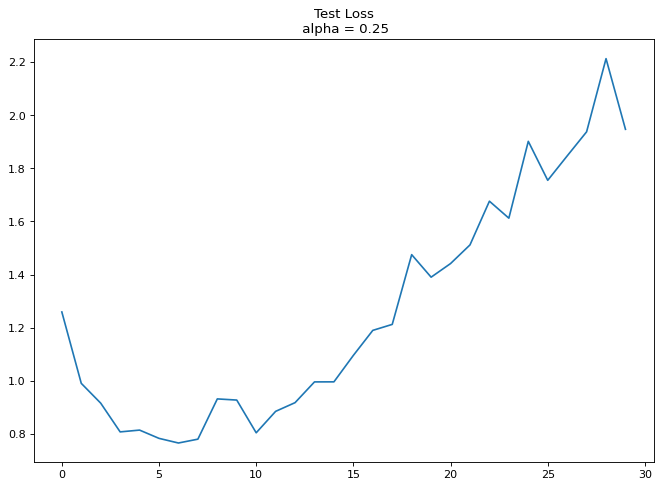

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_test_loss)
plt.title('Test Loss\n alpha = 0.25')
plt.show()

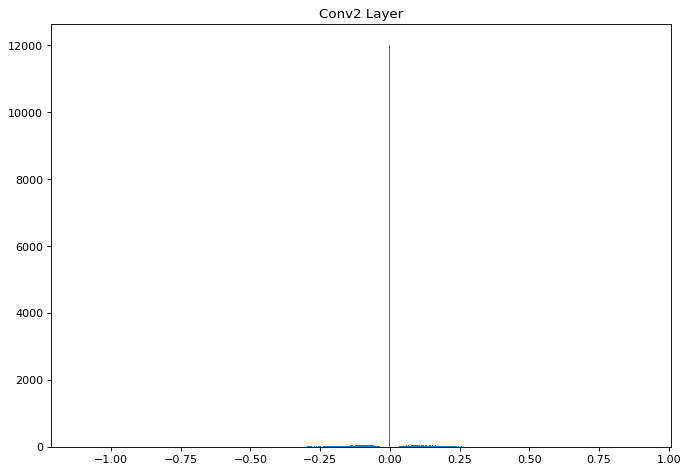

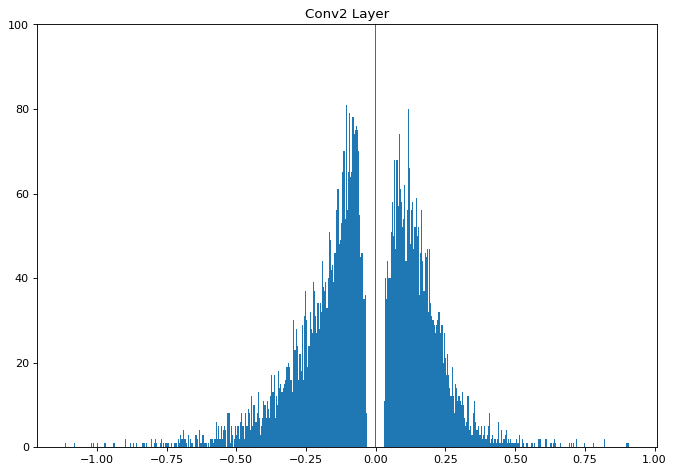

In [ ]:
for layer in model.layers:
  if layer.name == "conv2":
    a = tf.reshape(layer.weights[0],[-1])
    #print(a.shape)
    figure(figsize=(10, 7), dpi=80)
    plt.title('Conv2 Layer')
    plt.hist(a,500)
    plt.show()

    print("\n")
    figure(figsize=(10, 7), dpi=80)
    plt.title('Conv2 Layer')
    plt.hist(a,500)
    plt.ylim((0,100))
    plt.show()

In [ ]:
#QUANDO PRONTO, UTILIZAR APENAS EM NO PRUNE
accuracies = np.array([])
losses = np.array([])
spar = np.array([])

In [ ]:
accuracies = np.append(accuracies,model_train_acc, axis=0)
losses = np.append(losses,model_train_losse, axis=0)
spar = np.append(spar,model_sparsity,axis=0)

In [ ]:
#salvar status
np.savetxt("acc_train025.csv",model_train_acc,delimiter=",")
np.savetxt("loss_train025.csv",model_train_loss,delimiter=",")
np.savetxt("sparsity025.csv",model_sparsity,delimiter=",")
np.savetxt("acc_test-025.csv",model_test_acc,delimiter=",")
np.savetxt("acc_test-025.csv",model_test_loss,delimiter=",")

In [ ]:
np.savetxt("acc_test025.csv",model_test_acc,delimiter=",")
np.savetxt("loss_test025.csv",model_test_loss,delimiter=",")

In [ ]:
#salvar modelo
!mkdir -p saved_model
model.save('model025/model025')
!zip -r models.zip model025/

INFO:tensorflow:Assets written to: model025/model025/assets
  adding: model025/ (stored 0%)
  adding: model025/model025/ (stored 0%)
  adding: model025/model025/saved_model.pb (deflated 89%)
  adding: model025/model025/variables/ (stored 0%)
  adding: model025/model025/variables/variables.index (deflated 58%)
  adding: model025/model025/variables/variables.data-00000-of-00001 (deflated 21%)
  adding: model025/model025/assets/ (stored 0%)
  adding: model025/model025/keras_metadata.pb (deflated 93%)


# alpha = 0.5

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_accuracy = tf.keras.metrics.Accuracy()
test_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_accuracy = tf.keras.metrics.Accuracy()

In [ ]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),
     
        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu'),   
        keras.layers.Conv2D(64, (3, 3),name="conv2", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),
        keras.layers.Conv2D(128, (3, 3),name="conv3", activation='relu'),
        keras.layers.Conv2D(128, (3, 3),name="conv4", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),
     
        keras.layers.Flatten(name = "flatten"),
     
        keras.layers.Dense(256, name="dense1", activation='relu'),
        keras.layers.Dense(128, name="dense2", activation='relu'),
        keras.layers.Dense(10, name="dense3")
    ],
    name="modelo-0.5",
)
model.summary()

Model: "modelo-0.5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (64, 30, 30, 32)          896       
_________________________________________________________________
conv2 (Conv2D)               (64, 28, 28, 64)          18496     
_________________________________________________________________
mp1 (MaxPooling2D)           (64, 14, 14, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (64, 12, 12, 128)         73856     
_________________________________________________________________
conv4 (Conv2D)               (64, 10, 10, 128)         147584    
_________________________________________________________________
mp2 (MaxPooling2D)           (64, 5, 5, 128)           0         
_________________________________________________________________
flatten (Flatten)            (64, 3200)                0

In [ ]:
epochs = 30
alpha = 0.5
np.set_printoptions(threshold=np.inf)


model_sparsity = np.array([])

model_sparsity_layers = np.array([])

model_train_loss = np.array([])
model_train_acc = np.array([])

model_test_loss = np.array([])
model_test_acc = np.array([])
sparsity = 0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    # Iterate over the batches of the dataset.
    acc_epoch_mean = np.array([])
    loss_epoch_mean = np.array([])

    acct_epoch_mean = np.array([])
    losst_epoch_mean = np.array([])
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
      #sparsity_batch = np.array([])
      #Verify if the model needs to be pruned
      n_zeros = 0
      size = 0
      
      if alpha > 0:
        for layer_weights in model.trainable_variables:
          #flatten weights
          f_weights = tf.reshape(layer_weights,[-1])

          #get standard deviation of each layer
          lim = alpha*tf.math.reduce_std(f_weights)

          #create a mask
          mask = tf.cast(tf.where(tf.abs(layer_weights)>lim,1,0), tf.float32)

          #assign pruned weights to the layer
          layer_weights.assign(tf.math.multiply(layer_weights,mask))

          #check sparsity
          flat_array = np.array((tf.reshape(mask,[-1])))
          n_zeros += np.count_nonzero(np.array(flat_array) == 0)
          
          #n_zeros = np.count_nonzero(m)
          size += flat_array.shape[0]

          #print(size)
          #print(n_zeros)
          sparsity = n_zeros*100/size


      with tf.GradientTape() as tape:
        pred = model(x_batch_train, training=True)
        loss = loss_fn(y_batch_train, pred)
        
      grads = tape.gradient(loss, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      #acc = acc_metric(y_batch_train, pred)
      predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
      acc = train_accuracy(y_batch_train, predictions)

      acc_epoch_mean = np.append(acc_epoch_mean, acc)
      loss_epoch_mean = np.append(loss_epoch_mean, loss)


      if step % 50 == 0:
        print("So far", step, "m_batches ->","train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity)
        #print("train loss = ",float(loss), "train accuracy = ", float(acc*100), "sparsity = ", sparsity)

      if step == 781:
        print("Last train values over the epoch:", epoch)
        print("So far", step, "m_batches ->","train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity,"\n")


    #Test
    for step, (x_batch_test, y_batch_test) in enumerate(test_ds):
      test_pred = model(x_batch_test, training=False)
      test_loss = loss_fn(y_batch_test,test_pred)
      test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
      test_acc = test_accuracy(y_batch_test, test_prediction)

      acct_epoch_mean = np.append(acct_epoch_mean, test_acc)
      losst_epoch_mean = np.append(losst_epoch_mean, test_loss)
      if step == 156:
        print("\nLast train values over the epoch:", epoch)
        print("train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity,"\n")
      
    #acc = acca(y_batch_train, pred)
    #if step % 100 == 0:
    #  print("loss = ",float(loss), "accuracy = ", float(acc*100))
    
    print("test loss =",float(test_loss), "test accuracy =", float(test_acc*100))

    #model_test_acc = np.append(model_test_acc, test_acc*100)
    #model_test_loss = np.append(model_test_loss,test_loss)

    #save mean results on lists
    model_test_acc = np.append(model_test_acc, np.mean(acct_epoch_mean)*100)
    model_test_loss = np.append(model_test_loss,np.mean(losst_epoch_mean))

    model_sparsity = np.append(model_sparsity,sparsity)

    model_train_acc = np.append(model_train_acc, np.mean(acc_epoch_mean)*100)
    model_train_loss = np.append(model_train_loss,np.mean(loss_epoch_mean))


Start of epoch 0
So far 0 m_batches -> train loss = 2.292144775390625 train acc = 21.875 sparsity = 28.940660079636427
So far 50 m_batches -> train loss = 2.071402072906494 train acc = 15.900735855102539 sparsity = 34.12360640819243
So far 100 m_batches -> train loss = 1.7702851295471191 train acc = 22.076112747192383 sparsity = 35.96275471139561
So far 150 m_batches -> train loss = 1.768667459487915 train acc = 25.755382537841797 sparsity = 37.21330977254827
So far 200 m_batches -> train loss = 1.6428290605545044 train acc = 28.84794807434082 sparsity = 38.19049150550858
So far 250 m_batches -> train loss = 1.7559008598327637 train acc = 31.287351608276367 sparsity = 38.96456197223507
So far 300 m_batches -> train loss = 1.430198311805725 train acc = 33.03571319580078 sparsity = 39.79491518300115
So far 350 m_batches -> train loss = 1.2103264331817627 train acc = 34.75338363647461 sparsity = 40.4506639719171
So far 400 m_batches -> train loss = 1.5247900485992432 train acc = 36.08556

In [ ]:
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(x_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, y_test)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 71.900%


Confusion matrix, without normalization


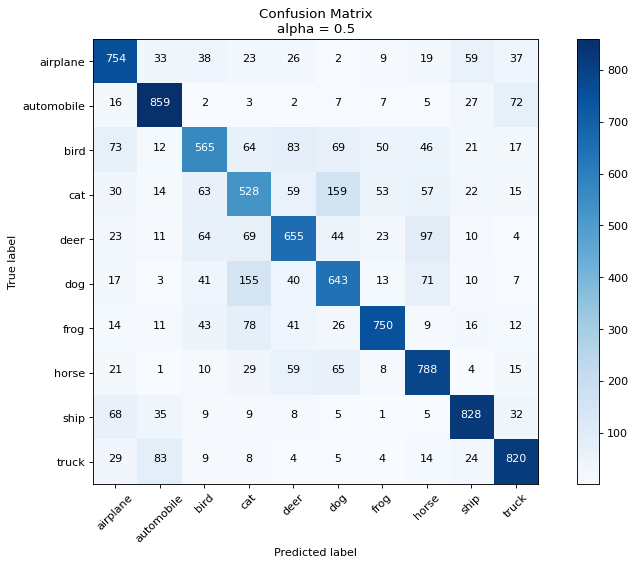

In [ ]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
cm = confusion_matrix(y_true=y_test, y_pred=prediction)
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix\nalpha = 0.5')

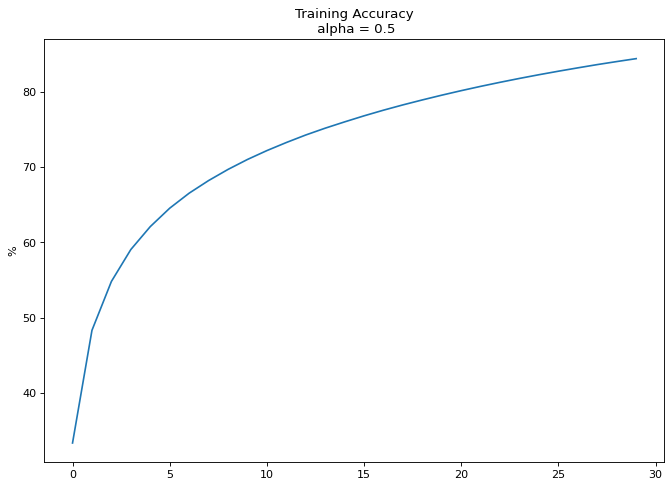

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_train_acc)
plt.title('Training Accuracy\n alpha = 0.5')
plt.ylabel('%')
plt.show()

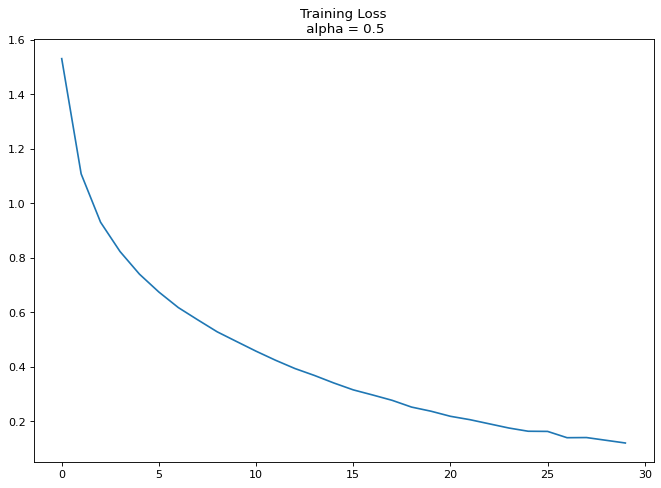

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_train_loss)
plt.title('Training Loss\n alpha = 0.5')
plt.show()

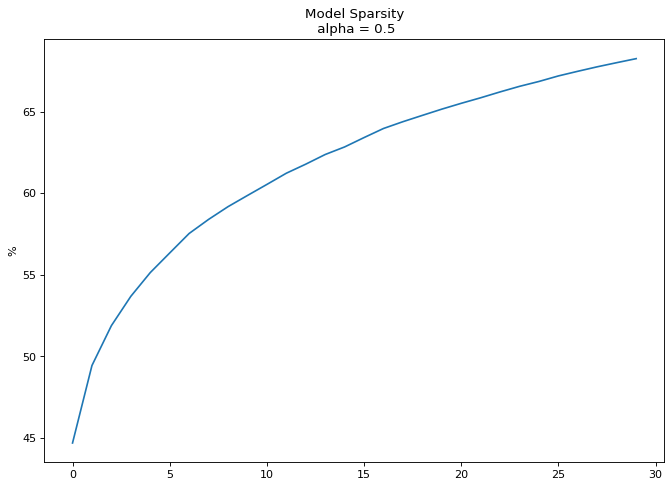

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_sparsity)
plt.title('Model Sparsity\n alpha = 0.5')
plt.ylabel('%')
plt.show()

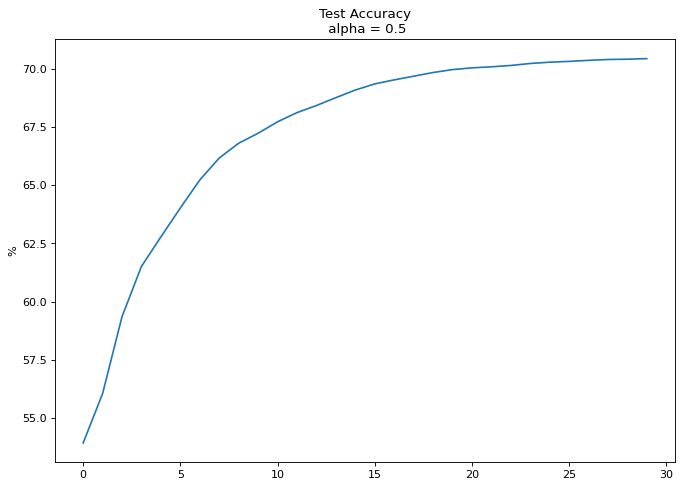

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_test_acc)
plt.title('Test Accuracy\n alpha = 0.5')
plt.ylabel('%')
plt.show()

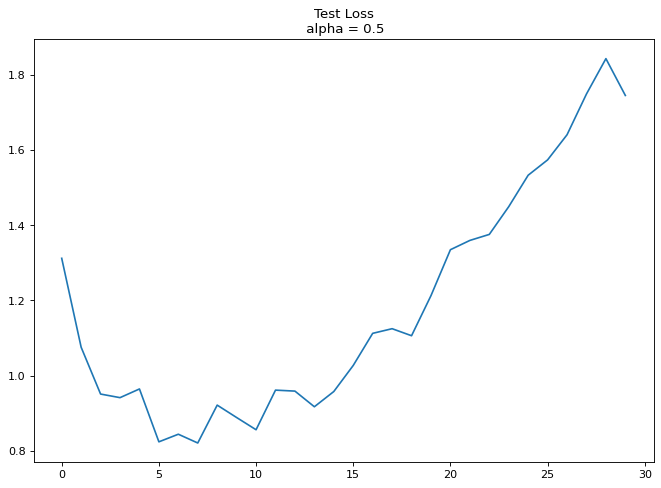

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_test_loss)
plt.title('Test Loss\n alpha = 0.5')
plt.show()

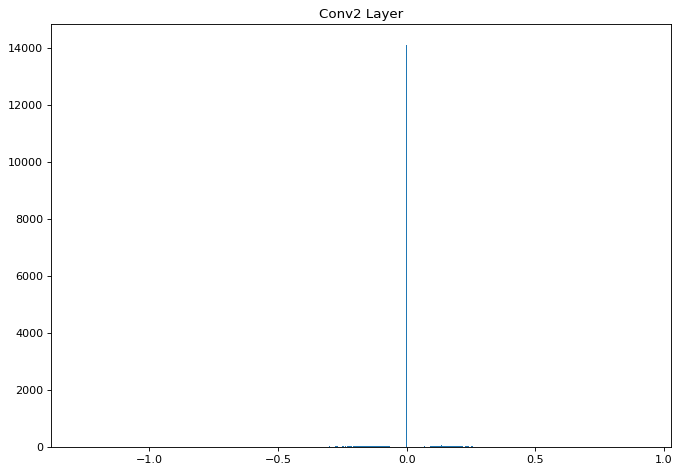

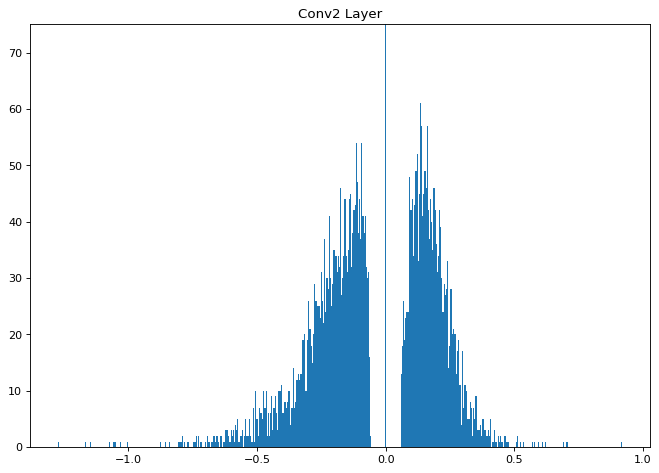

In [ ]:
for layer in model.layers:
  if layer.name == "conv2":
    a = tf.reshape(layer.weights[0],[-1])
    #print(a.shape)
    figure(figsize=(10, 7), dpi=80)
    plt.title('Conv2 Layer')
    plt.hist(a,500)
    plt.show()

    print("\n")
    figure(figsize=(10, 7), dpi=80)
    plt.title('Conv2 Layer')
    plt.hist(a,500)
    plt.ylim((0,75))
    plt.show()

In [ ]:
#salvar status
np.savetxt("acc_train05.csv",model_train_acc,delimiter=",")
np.savetxt("loss_train05.csv",model_train_loss,delimiter=",")
np.savetxt("sparsity05.csv",model_sparsity,delimiter=",")
np.savetxt("acc_test-05.csv",model_test_acc,delimiter=",")
np.savetxt("loss_test-05.csv",model_test_loss,delimiter=",")

In [ ]:
#salvar modelo
!mkdir -p saved_model
model.save('model05/model05')
!zip -r models.zip model05/

INFO:tensorflow:Assets written to: model05/model05/assets
  adding: model05/ (stored 0%)
  adding: model05/model05/ (stored 0%)
  adding: model05/model05/saved_model.pb (deflated 90%)
  adding: model05/model05/variables/ (stored 0%)
  adding: model05/model05/variables/variables.index (deflated 58%)
  adding: model05/model05/variables/variables.data-00000-of-00001 (deflated 33%)
  adding: model05/model05/assets/ (stored 0%)
  adding: model05/model05/keras_metadata.pb (deflated 93%)


# alpha = 0.75

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_accuracy = tf.keras.metrics.Accuracy()
test_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_accuracy = tf.keras.metrics.Accuracy()

In [ ]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),
     
        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu'),   
        keras.layers.Conv2D(64, (3, 3),name="conv2", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),
        keras.layers.Conv2D(128, (3, 3),name="conv3", activation='relu'),
        keras.layers.Conv2D(128, (3, 3),name="conv4", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),
     
        keras.layers.Flatten(name = "flatten"),
     
        keras.layers.Dense(256, name="dense1", activation='relu'),
        keras.layers.Dense(128, name="dense2", activation='relu'),
        keras.layers.Dense(10, name="dense3")
    ],
    name="modelo-0.75",
)
model.summary()

Model: "modelo-0.5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (64, 30, 30, 32)          896       
_________________________________________________________________
conv2 (Conv2D)               (64, 28, 28, 64)          18496     
_________________________________________________________________
mp1 (MaxPooling2D)           (64, 14, 14, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (64, 12, 12, 128)         73856     
_________________________________________________________________
conv4 (Conv2D)               (64, 10, 10, 128)         147584    
_________________________________________________________________
mp2 (MaxPooling2D)           (64, 5, 5, 128)           0         
_________________________________________________________________
flatten (Flatten)            (64, 3200)                0

In [ ]:
epochs = 30
alpha = 0.75
np.set_printoptions(threshold=np.inf)


model_sparsity = np.array([])

model_sparsity_layers = np.array([])

model_train_loss = np.array([])
model_train_acc = np.array([])

model_test_loss = np.array([])
model_test_acc = np.array([])
sparsity = 0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    # Iterate over the batches of the dataset.
    acc_epoch_mean = np.array([])
    loss_epoch_mean = np.array([])

    acct_epoch_mean = np.array([])
    losst_epoch_mean = np.array([])
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
      #sparsity_batch = np.array([])
      #Verify if the model needs to be pruned
      n_zeros = 0
      size = 0
      
      if alpha > 0:
        for layer_weights in model.trainable_variables:
          #flatten weights
          f_weights = tf.reshape(layer_weights,[-1])

          #get standard deviation of each layer
          lim = alpha*tf.math.reduce_std(f_weights)

          #create a mask
          mask = tf.cast(tf.where(tf.abs(layer_weights)>lim,1,0), tf.float32)

          #assign pruned weights to the layer
          layer_weights.assign(tf.math.multiply(layer_weights,mask))

          #check sparsity
          flat_array = np.array((tf.reshape(mask,[-1])))
          n_zeros += np.count_nonzero(np.array(flat_array) == 0)
          
          #n_zeros = np.count_nonzero(m)
          size += flat_array.shape[0]

          #print(size)
          #print(n_zeros)
          sparsity = n_zeros*100/size


      with tf.GradientTape() as tape:
        pred = model(x_batch_train, training=True)
        loss = loss_fn(y_batch_train, pred)
        
      grads = tape.gradient(loss, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      #acc = acc_metric(y_batch_train, pred)
      predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
      acc = train_accuracy(y_batch_train, predictions)

      acc_epoch_mean = np.append(acc_epoch_mean, acc)
      loss_epoch_mean = np.append(loss_epoch_mean, loss)


      if step % 50 == 0:
        print("So far", step, "m_batches ->","train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity)
        #print("train loss = ",float(loss), "train accuracy = ", float(acc*100), "sparsity = ", sparsity)

      if step == 781:
        print("Last train values over the epoch:", epoch)
        print("So far", step, "m_batches ->","train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity,"\n")


    #Test
    for step, (x_batch_test, y_batch_test) in enumerate(test_ds):
      test_pred = model(x_batch_test, training=False)
      test_loss = loss_fn(y_batch_test,test_pred)
      test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
      test_acc = test_accuracy(y_batch_test, test_prediction)

      acct_epoch_mean = np.append(acct_epoch_mean, test_acc)
      losst_epoch_mean = np.append(losst_epoch_mean, test_loss)
      if step == 156:
        print("\nLast train values over the epoch:", epoch)
        print("train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity,"\n")
      
    #acc = acca(y_batch_train, pred)
    #if step % 100 == 0:
    #  print("loss = ",float(loss), "accuracy = ", float(acc*100))
    
    print("test loss =",float(test_loss), "test accuracy =", float(test_acc*100))

    #model_test_acc = np.append(model_test_acc, test_acc*100)
    #model_test_loss = np.append(model_test_loss,test_loss)

    #save mean results on lists
    model_test_acc = np.append(model_test_acc, np.mean(acct_epoch_mean)*100)
    model_test_loss = np.append(model_test_loss,np.mean(losst_epoch_mean))

    model_sparsity = np.append(model_sparsity,sparsity)

    model_train_acc = np.append(model_train_acc, np.mean(acc_epoch_mean)*100)
    model_train_loss = np.append(model_train_loss,np.mean(loss_epoch_mean))


Start of epoch 0
So far 0 m_batches -> train loss = 2.3028740882873535 train acc = 14.0625 sparsity = 43.36293050360264
So far 50 m_batches -> train loss = 1.885817527770996 train acc = 18.627450942993164 sparsity = 48.44034668708439
So far 100 m_batches -> train loss = 1.806799054145813 train acc = 24.706064224243164 sparsity = 50.46451537450867
So far 150 m_batches -> train loss = 1.6454044580459595 train acc = 28.590646743774414 sparsity = 51.692045676736036
So far 200 m_batches -> train loss = 1.711742639541626 train acc = 31.265548706054688 sparsity = 52.62966502630487
So far 250 m_batches -> train loss = 1.7031190395355225 train acc = 33.14242935180664 sparsity = 53.419268068496834
So far 300 m_batches -> train loss = 1.3747296333312988 train acc = 34.857765197753906 sparsity = 54.27228056582431
So far 350 m_batches -> train loss = 1.775810956954956 train acc = 36.066593170166016 sparsity = 54.96147007603653
So far 400 m_batches -> train loss = 1.23427414894104 train acc = 37.34

In [ ]:
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(x_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, y_test)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 71.840%


Confusion matrix, without normalization


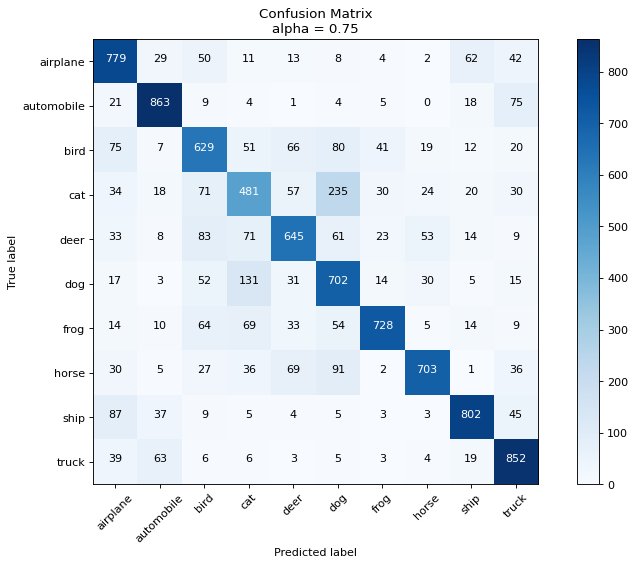

In [ ]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
cm = confusion_matrix(y_true=y_test, y_pred=prediction)
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix\nalpha = 0.75')

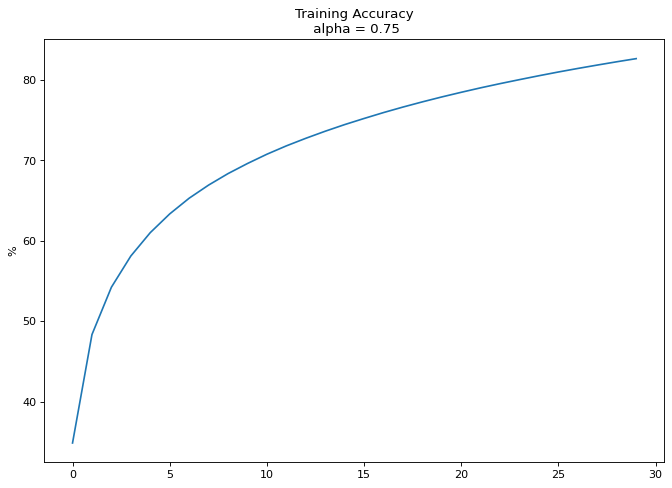

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_train_acc)
plt.title('Training Accuracy\n alpha = 0.75')
plt.ylabel('%')
plt.show()

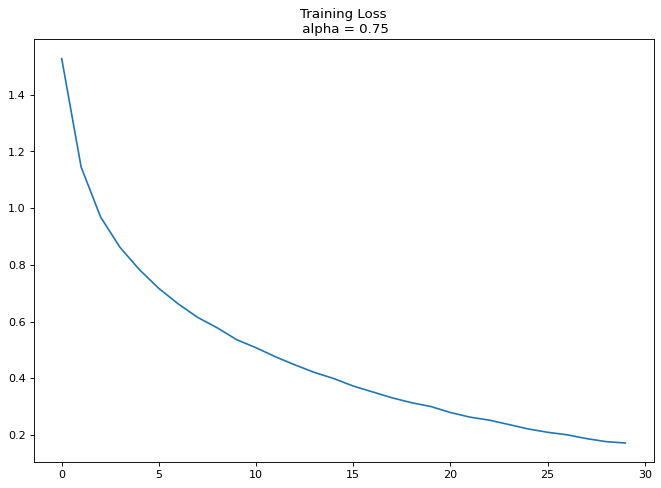

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_train_loss)
plt.title('Training Loss\n alpha = 0.75')
plt.show()

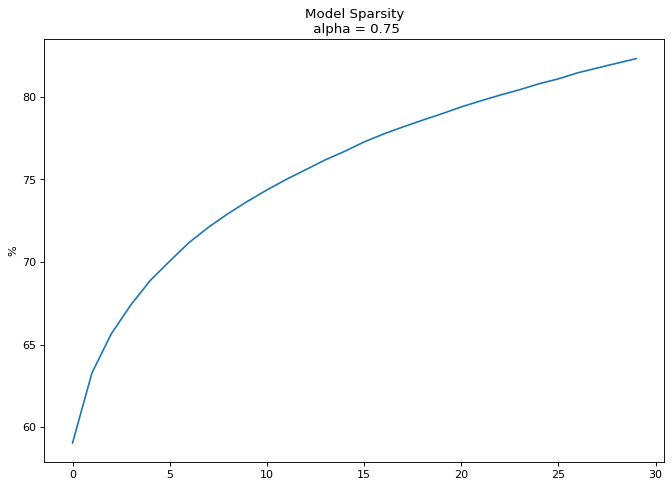

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_sparsity)
plt.title('Model Sparsity\n alpha = 0.75')
plt.ylabel('%')
plt.show()

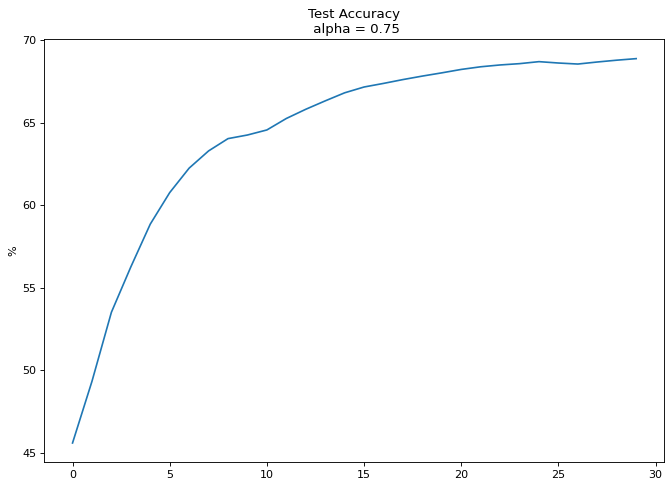

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_test_acc)
plt.title('Test Accuracy\n alpha = 0.75')
plt.ylabel('%')
plt.show()

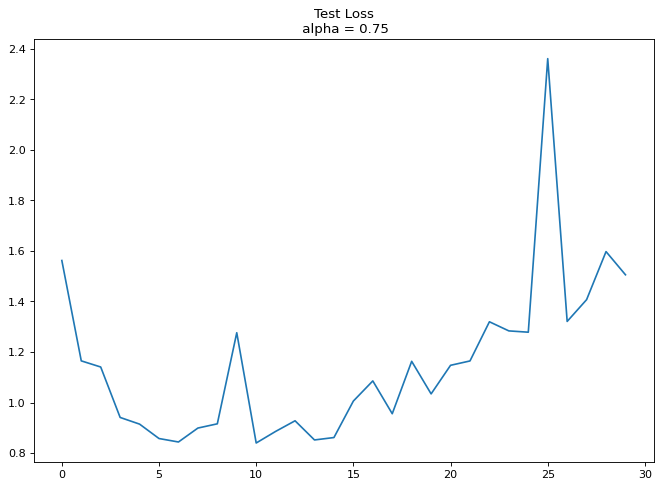

In [ ]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_test_loss)
plt.title('Test Loss\n alpha = 0.75')
plt.show()

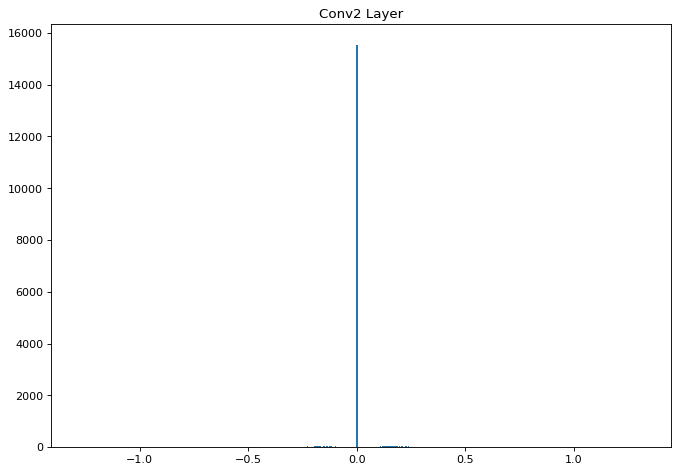

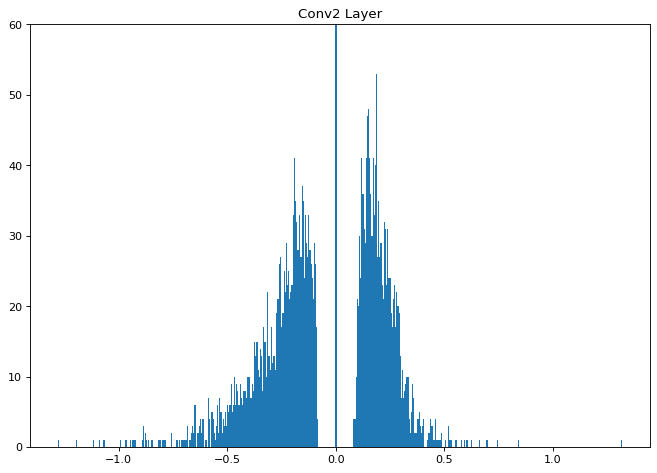

In [ ]:
for layer in model.layers:
  if layer.name == "conv2":
    a = tf.reshape(layer.weights[0],[-1])
    #print(a.shape)
    figure(figsize=(10, 7), dpi=80)
    plt.title('Conv2 Layer')
    plt.hist(a,500)
    plt.show()

    print("\n")
    figure(figsize=(10, 7), dpi=80)
    plt.title('Conv2 Layer')
    plt.hist(a,500)
    plt.ylim((0,60))
    plt.show()

In [ ]:
#salvar status
np.savetxt("acc_train075.csv",model_train_acc,delimiter=",")
np.savetxt("loss_train075.csv",model_train_loss,delimiter=",")
np.savetxt("sparsity075.csv",model_sparsity,delimiter=",")
np.savetxt("acc_test-075.csv",model_test_acc,delimiter=",")
np.savetxt("loss_test-075.csv",model_test_loss,delimiter=",")

In [ ]:
#salvar modelo
!mkdir -p saved_model
model.save('model075/model075')
!zip -r models075.zip model075/

INFO:tensorflow:Assets written to: model075/model075/assets
  adding: model075/ (stored 0%)
  adding: model075/model075/ (stored 0%)
  adding: model075/model075/saved_model.pb (deflated 90%)
  adding: model075/model075/variables/ (stored 0%)
  adding: model075/model075/variables/variables.index (deflated 58%)
  adding: model075/model075/variables/variables.data-00000-of-00001 (deflated 40%)
  adding: model075/model075/assets/ (stored 0%)
  adding: model075/model075/keras_metadata.pb (deflated 93%)


# alpha = 1.0

In [54]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_accuracy = tf.keras.metrics.Accuracy()
test_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_accuracy = tf.keras.metrics.Accuracy()

In [55]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),
     
        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu'),   
        keras.layers.Conv2D(64, (3, 3),name="conv2", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),
        keras.layers.Conv2D(128, (3, 3),name="conv3", activation='relu'),
        keras.layers.Conv2D(128, (3, 3),name="conv4", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),
     
        keras.layers.Flatten(name = "flatten"),
     
        keras.layers.Dense(256, name="dense1", activation='relu'),
        keras.layers.Dense(128, name="dense2", activation='relu'),
        keras.layers.Dense(10, name="dense3")
    ],
    name="modelo-1.0",
)
model.summary()

Model: "modelo-1.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (64, 30, 30, 32)          896       
_________________________________________________________________
conv2 (Conv2D)               (64, 28, 28, 64)          18496     
_________________________________________________________________
mp1 (MaxPooling2D)           (64, 14, 14, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (64, 12, 12, 128)         73856     
_________________________________________________________________
conv4 (Conv2D)               (64, 10, 10, 128)         147584    
_________________________________________________________________
mp2 (MaxPooling2D)           (64, 5, 5, 128)           0         
_________________________________________________________________
flatten (Flatten)            (64, 3200)                0

In [56]:
epochs = 30
alpha = 1.0
np.set_printoptions(threshold=np.inf)


model_sparsity = np.array([])

model_sparsity_layers = np.array([])

model_train_loss = np.array([])
model_train_acc = np.array([])

model_test_loss = np.array([])
model_test_acc = np.array([])
sparsity = 0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    # Iterate over the batches of the dataset.
    acc_epoch_mean = np.array([])
    loss_epoch_mean = np.array([])

    acct_epoch_mean = np.array([])
    losst_epoch_mean = np.array([])
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
      #sparsity_batch = np.array([])
      #Verify if the model needs to be pruned
      n_zeros = 0
      size = 0
      
      if alpha > 0:
        for layer_weights in model.trainable_variables:
          #flatten weights
          f_weights = tf.reshape(layer_weights,[-1])

          #get standard deviation of each layer
          lim = alpha*tf.math.reduce_std(f_weights)

          #create a mask
          mask = tf.cast(tf.where(tf.abs(layer_weights)>lim,1,0), tf.float32)

          #assign pruned weights to the layer
          layer_weights.assign(tf.math.multiply(layer_weights,mask))

          #check sparsity
          flat_array = np.array((tf.reshape(mask,[-1])))
          n_zeros += np.count_nonzero(np.array(flat_array) == 0)
          
          #n_zeros = np.count_nonzero(m)
          size += flat_array.shape[0]

          #print(size)
          #print(n_zeros)
          sparsity = n_zeros*100/size


      with tf.GradientTape() as tape:
        pred = model(x_batch_train, training=True)
        loss = loss_fn(y_batch_train, pred)
        
      grads = tape.gradient(loss, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      #acc = acc_metric(y_batch_train, pred)
      predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
      acc = train_accuracy(y_batch_train, predictions)

      acc_epoch_mean = np.append(acc_epoch_mean, acc)
      loss_epoch_mean = np.append(loss_epoch_mean, loss)


      if step % 50 == 0:
        print("So far", step, "m_batches ->","train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity)
        #print("train loss = ",float(loss), "train accuracy = ", float(acc*100), "sparsity = ", sparsity)

      if step == 781:
        print("Last train values over the epoch:", epoch)
        print("So far", step, "m_batches ->","train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity,"\n")


    #Test
    for step, (x_batch_test, y_batch_test) in enumerate(test_ds):
      test_pred = model(x_batch_test, training=False)
      test_loss = loss_fn(y_batch_test,test_pred)
      test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
      test_acc = test_accuracy(y_batch_test, test_prediction)

      acct_epoch_mean = np.append(acct_epoch_mean, test_acc)
      losst_epoch_mean = np.append(losst_epoch_mean, test_loss)
      if step == 156:
        print("\nLast train values over the epoch:", epoch)
        print("train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity,"\n")
      
    #acc = acca(y_batch_train, pred)
    #if step % 100 == 0:
    #  print("loss = ",float(loss), "accuracy = ", float(acc*100))
    
    print("test loss =",float(test_loss), "test accuracy =", float(test_acc*100))

    #model_test_acc = np.append(model_test_acc, test_acc*100)
    #model_test_loss = np.append(model_test_loss,test_loss)

    #save mean results on lists
    model_test_acc = np.append(model_test_acc, np.mean(acct_epoch_mean)*100)
    model_test_loss = np.append(model_test_loss,np.mean(losst_epoch_mean))

    model_sparsity = np.append(model_sparsity,sparsity)

    model_train_acc = np.append(model_train_acc, np.mean(acc_epoch_mean)*100)
    model_train_loss = np.append(model_train_loss,np.mean(loss_epoch_mean))


Start of epoch 0
So far 0 m_batches -> train loss = 2.3042378425598145 train acc = 10.9375 sparsity = 57.752034310545525
So far 50 m_batches -> train loss = 2.050571918487549 train acc = 18.382352828979492 sparsity = 61.87282658153597
So far 100 m_batches -> train loss = 1.84151291847229 train acc = 23.76237678527832 sparsity = 63.826915943183664
So far 150 m_batches -> train loss = 1.7365673780441284 train acc = 27.566225051879883 sparsity = 65.16308290557839
So far 200 m_batches -> train loss = 1.5483193397521973 train acc = 30.23942756652832 sparsity = 66.23729755115242
So far 250 m_batches -> train loss = 1.713207721710205 train acc = 31.972110748291016 sparsity = 67.06874717901019
So far 300 m_batches -> train loss = 1.532762050628662 train acc = 33.63268280029297 sparsity = 67.79073783388185
So far 350 m_batches -> train loss = 1.5058685541152954 train acc = 35.118412017822266 sparsity = 68.38453905711785
So far 400 m_batches -> train loss = 1.3649485111236572 train acc = 36.479

In [57]:
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(x_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, y_test)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 64.220%


Confusion matrix, without normalization


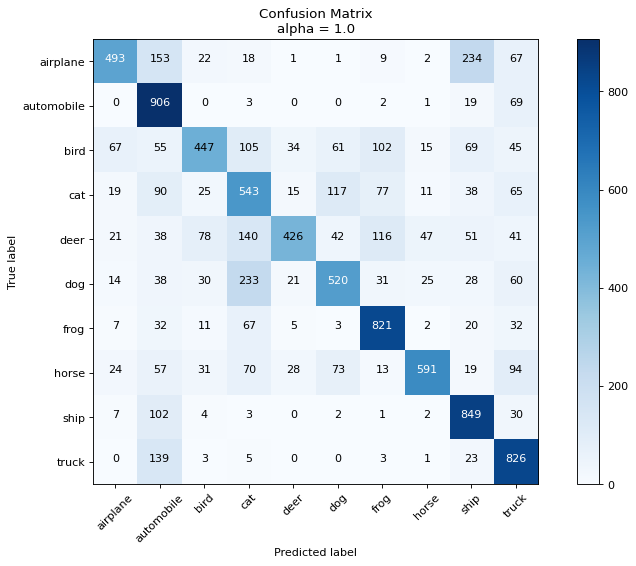

In [58]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
cm = confusion_matrix(y_true=y_test, y_pred=prediction)
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix\nalpha = 1.0')

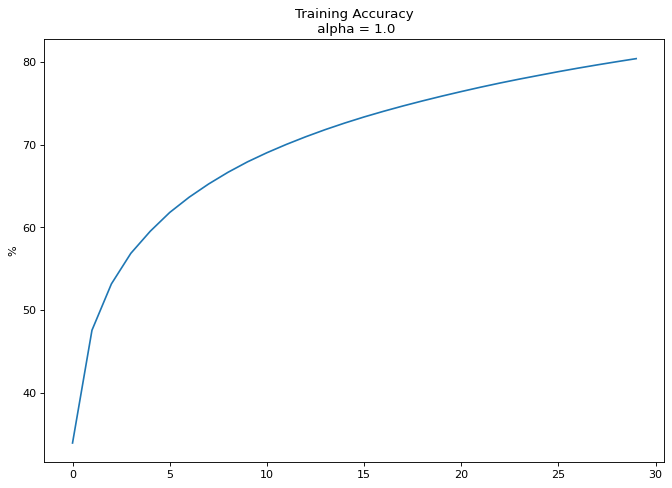

In [59]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_train_acc)
plt.title('Training Accuracy\n alpha = 1.0')
plt.ylabel('%')
plt.show()

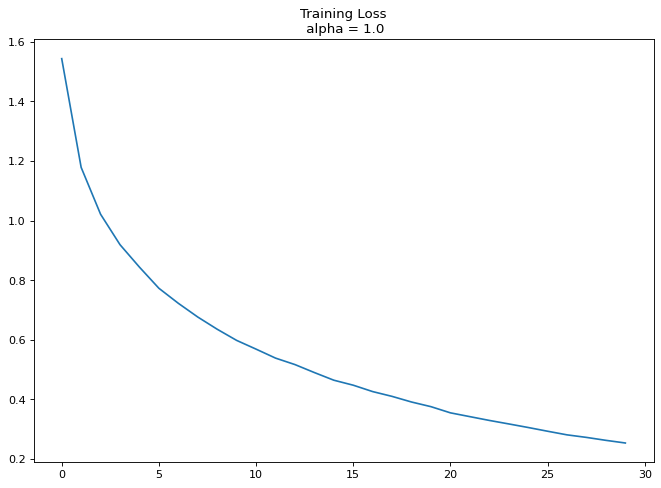

In [60]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_train_loss)
plt.title('Training Loss\n alpha = 1.0')
plt.show()

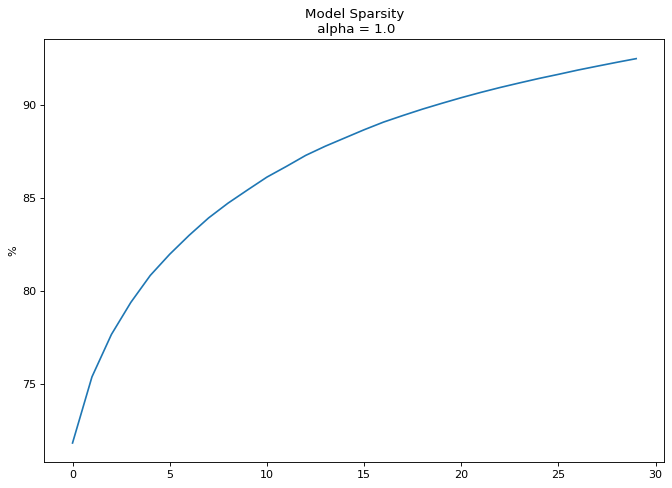

In [61]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_sparsity)
plt.title('Model Sparsity\n alpha = 1.0')
plt.ylabel('%')
plt.show()

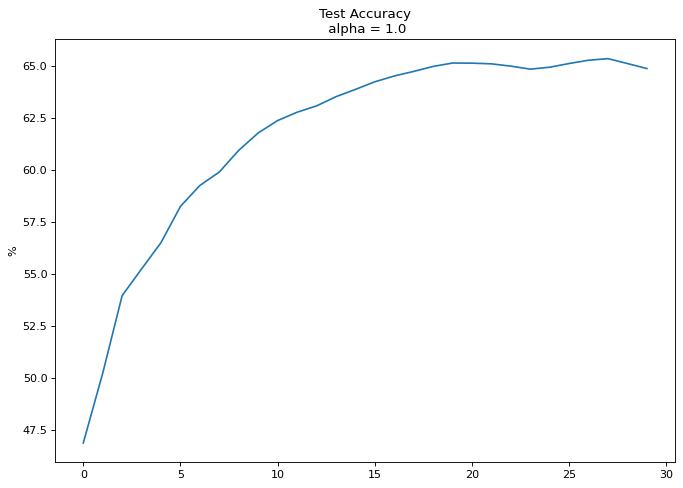

In [62]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_test_acc)
plt.title('Test Accuracy\n alpha = 1.0')
plt.ylabel('%')
plt.show()

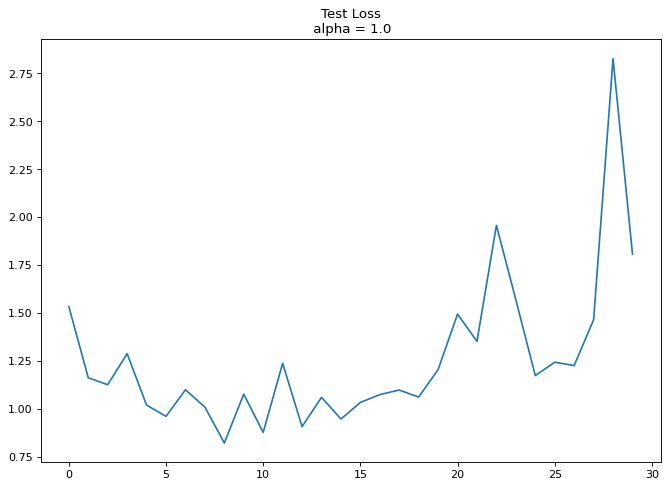

In [63]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_test_loss)
plt.title('Test Loss\n alpha = 1.0')
plt.show()

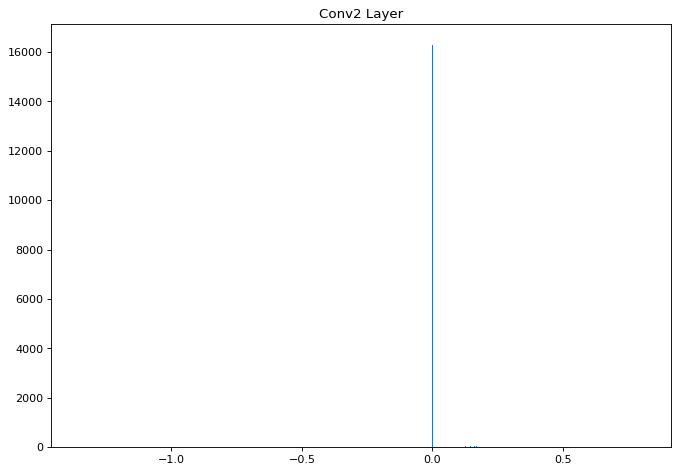

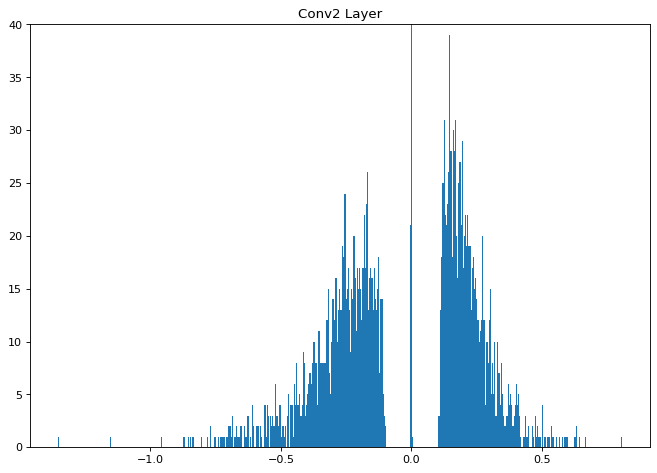

In [64]:
for layer in model.layers:
  if layer.name == "conv2":
    a = tf.reshape(layer.weights[0],[-1])
    #print(a.shape)
    figure(figsize=(10, 7), dpi=80)
    plt.title('Conv2 Layer')
    plt.hist(a,500)
    plt.show()

    print("\n")
    figure(figsize=(10, 7), dpi=80)
    plt.title('Conv2 Layer')
    plt.hist(a,500)
    plt.ylim((0,40))
    plt.show()

In [66]:
#salvar status
np.savetxt("acc_train10-.csv",model_train_acc,delimiter=",")
np.savetxt("loss_train10-.csv",model_train_loss,delimiter=",")
np.savetxt("sparsity10-.csv",model_sparsity,delimiter=",")
np.savetxt("acc_test-10-.csv",model_test_acc,delimiter=",")
np.savetxt("loss_test-10-.csv",model_test_loss,delimiter=",")

In [67]:
#salvar modelo
!mkdir -p saved_model
model.save('model10-/model0-')
!zip -r models10-.zip model10-/

INFO:tensorflow:Assets written to: model10-/model0-/assets
  adding: model10-/ (stored 0%)
  adding: model10-/model0-/ (stored 0%)
  adding: model10-/model0-/saved_model.pb (deflated 90%)
  adding: model10-/model0-/variables/ (stored 0%)
  adding: model10-/model0-/variables/variables.index (deflated 58%)
  adding: model10-/model0-/variables/variables.data-00000-of-00001 (deflated 41%)
  adding: model10-/model0-/assets/ (stored 0%)
  adding: model10-/model0-/keras_metadata.pb (deflated 93%)


# alpha = 1.25

In [29]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_accuracy = tf.keras.metrics.Accuracy()
test_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_accuracy = tf.keras.metrics.Accuracy()

In [30]:
model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),
     
        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu'),   
        keras.layers.Conv2D(64, (3, 3),name="conv2", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),
        keras.layers.Conv2D(128, (3, 3),name="conv3", activation='relu'),
        keras.layers.Conv2D(128, (3, 3),name="conv4", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),
     
        keras.layers.Flatten(name = "flatten"),
     
        keras.layers.Dense(256, name="dense1", activation='relu'),
        keras.layers.Dense(128, name="dense2", activation='relu'),
        keras.layers.Dense(10, name="dense3")
    ],
    name="modelo-1.25",
)
model.summary()

Model: "modelo-1.25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (64, 30, 30, 32)          896       
_________________________________________________________________
conv2 (Conv2D)               (64, 28, 28, 64)          18496     
_________________________________________________________________
mp1 (MaxPooling2D)           (64, 14, 14, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (64, 12, 12, 128)         73856     
_________________________________________________________________
conv4 (Conv2D)               (64, 10, 10, 128)         147584    
_________________________________________________________________
mp2 (MaxPooling2D)           (64, 5, 5, 128)           0         
_________________________________________________________________
flatten (Flatten)            (64, 3200)                

In [31]:
epochs = 30
alpha = 1.25
np.set_printoptions(threshold=np.inf)


model_sparsity = np.array([])

model_sparsity_layers = np.array([])

model_train_loss = np.array([])
model_train_acc = np.array([])

model_test_loss = np.array([])
model_test_acc = np.array([])
sparsity = 0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    # Iterate over the batches of the dataset.
    acc_epoch_mean = np.array([])
    loss_epoch_mean = np.array([])

    acct_epoch_mean = np.array([])
    losst_epoch_mean = np.array([])
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
      #sparsity_batch = np.array([])
      #Verify if the model needs to be pruned
      n_zeros = 0
      size = 0
      
      if alpha > 0:
        for layer_weights in model.trainable_variables:
          #flatten weights
          f_weights = tf.reshape(layer_weights,[-1])

          #get standard deviation of each layer
          lim = alpha*tf.math.reduce_std(f_weights)

          #create a mask
          mask = tf.cast(tf.where(tf.abs(layer_weights)>lim,1,0), tf.float32)

          #assign pruned weights to the layer
          layer_weights.assign(tf.math.multiply(layer_weights,mask))

          #check sparsity
          flat_array = np.array((tf.reshape(mask,[-1])))
          n_zeros += np.count_nonzero(np.array(flat_array) == 0)
          
          #n_zeros = np.count_nonzero(m)
          size += flat_array.shape[0]

          #print(size)
          #print(n_zeros)
          sparsity = n_zeros*100/size


      with tf.GradientTape() as tape:
        pred = model(x_batch_train, training=True)
        loss = loss_fn(y_batch_train, pred)
        
      grads = tape.gradient(loss, model.trainable_weights)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))
      #acc = acc_metric(y_batch_train, pred)
      predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
      acc = train_accuracy(y_batch_train, predictions)

      acc_epoch_mean = np.append(acc_epoch_mean, acc)
      loss_epoch_mean = np.append(loss_epoch_mean, loss)


      if step % 50 == 0:
        print("So far", step, "m_batches ->","train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity)
        #print("train loss = ",float(loss), "train accuracy = ", float(acc*100), "sparsity = ", sparsity)

      if step == 781:
        print("Last train values over the epoch:", epoch)
        print("So far", step, "m_batches ->","train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity,"\n")


    #Test
    for step, (x_batch_test, y_batch_test) in enumerate(test_ds):
      test_pred = model(x_batch_test, training=False)
      test_loss = loss_fn(y_batch_test,test_pred)
      test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
      test_acc = test_accuracy(y_batch_test, test_prediction)

      acct_epoch_mean = np.append(acct_epoch_mean, test_acc)
      losst_epoch_mean = np.append(losst_epoch_mean, test_loss)
      if step == 156:
        print("\nLast train values over the epoch:", epoch)
        print("train loss =",float(loss), "train acc =", float(acc*100), "sparsity =", sparsity,"\n")
      
    #acc = acca(y_batch_train, pred)
    #if step % 100 == 0:
    #  print("loss = ",float(loss), "accuracy = ", float(acc*100))
    
    print("test loss =",float(test_loss), "test accuracy =", float(test_acc*100))

    #model_test_acc = np.append(model_test_acc, test_acc*100)
    #model_test_loss = np.append(model_test_loss,test_loss)

    #save mean results on lists
    model_test_acc = np.append(model_test_acc, np.mean(acct_epoch_mean)*100)
    model_test_loss = np.append(model_test_loss,np.mean(losst_epoch_mean))

    model_sparsity = np.append(model_sparsity,sparsity)

    model_train_acc = np.append(model_train_acc, np.mean(acc_epoch_mean)*100)
    model_train_loss = np.append(model_train_loss,np.mean(loss_epoch_mean))


Start of epoch 0
So far 0 m_batches -> train loss = 2.306183338165283 train acc = 3.125 sparsity = 72.17393926214784
So far 50 m_batches -> train loss = 1.9390649795532227 train acc = 17.80024528503418 sparsity = 74.14886054853747
So far 100 m_batches -> train loss = 2.0940451622009277 train acc = 21.271657943725586 sparsity = 75.62043502175474
So far 150 m_batches -> train loss = 1.86692214012146 train acc = 24.234272003173828 sparsity = 76.62566675864387
So far 200 m_batches -> train loss = 1.5709327459335327 train acc = 27.098878860473633 sparsity = 77.37634699408117
So far 250 m_batches -> train loss = 1.7796318531036377 train acc = 29.513198852539062 sparsity = 77.90079983626838
So far 300 m_batches -> train loss = 1.7589893341064453 train acc = 31.094268798828125 sparsity = 78.36732530877846
So far 350 m_batches -> train loss = 1.4308286905288696 train acc = 32.63888931274414 sparsity = 78.78652211016434
So far 400 m_batches -> train loss = 1.6640777587890625 train acc = 33.8294

In [32]:
test_accuracy = tf.keras.metrics.Accuracy()
logits = model(x_test, training=False)
prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
test_accuracy(prediction, y_test)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 54.420%


Confusion matrix, without normalization


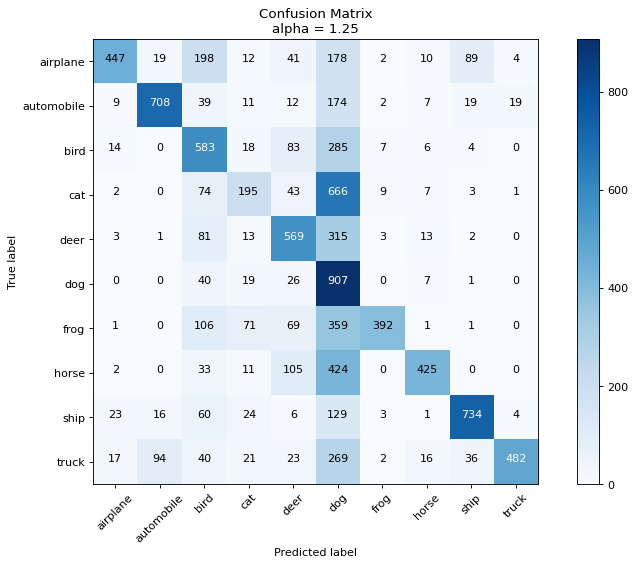

In [38]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
cm = confusion_matrix(y_true=y_test, y_pred=prediction)
plot_confusion_matrix(cm=cm, classes=classes, title='Confusion Matrix\nalpha = 1.25')

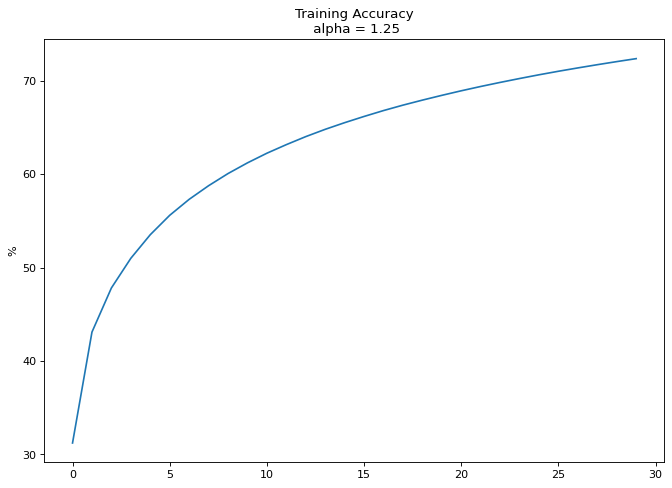

In [39]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_train_acc)
plt.title('Training Accuracy\n alpha = 1.25')
plt.ylabel('%')
plt.show()

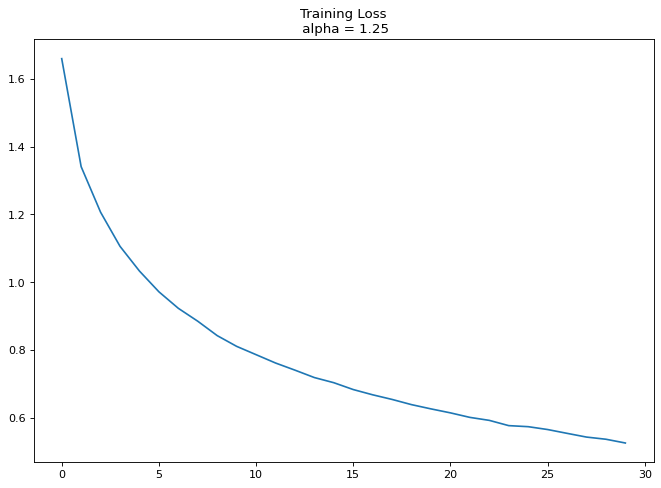

In [40]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_train_loss)
plt.title('Training Loss\n alpha = 1.25')
plt.show()

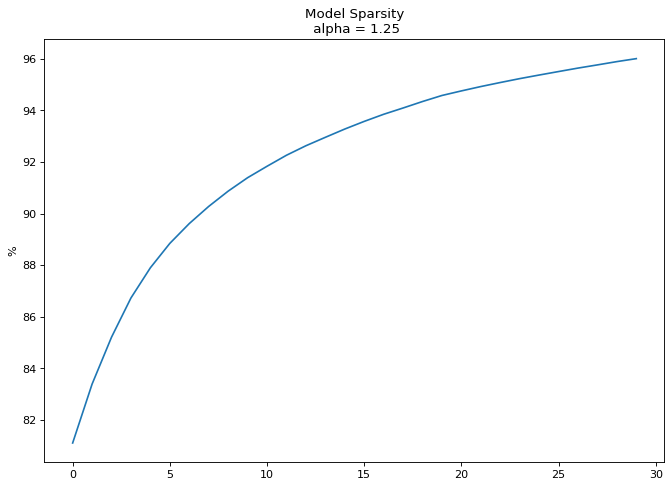

In [41]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_sparsity)
plt.title('Model Sparsity\n alpha = 1.25')
plt.ylabel('%')
plt.show()

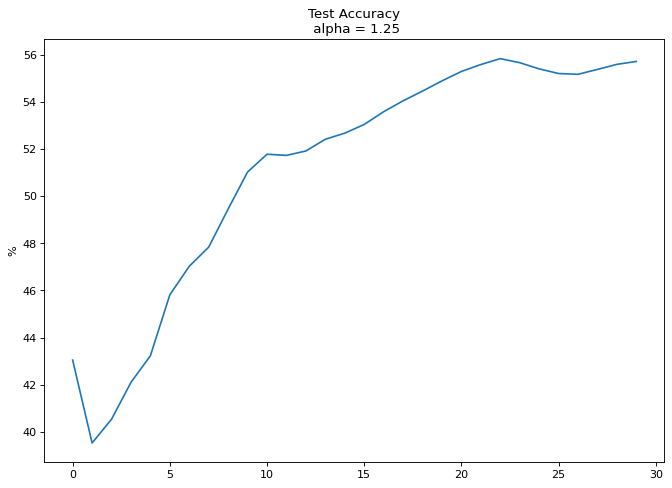

In [42]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_test_acc)
plt.title('Test Accuracy\n alpha = 1.25')
plt.ylabel('%')
plt.show()

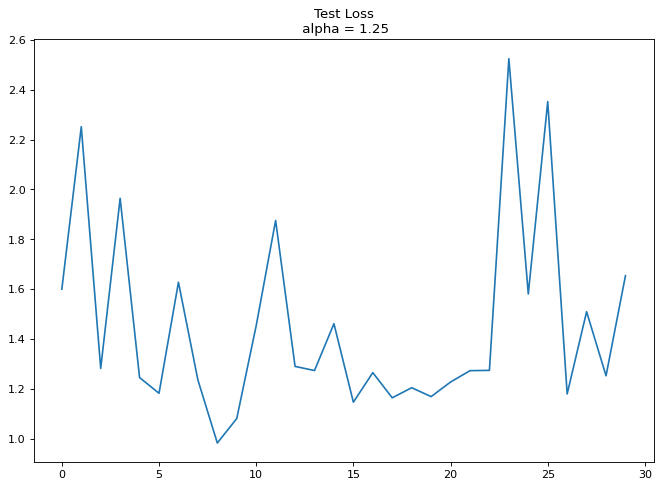

In [44]:
figure(figsize=(10, 7), dpi=80)
plt.plot(model_test_loss)
plt.title('Test Loss\n alpha = 1.25')
plt.show()

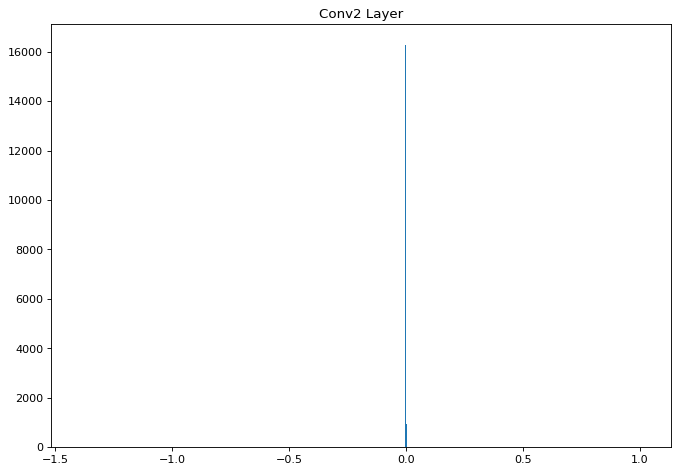

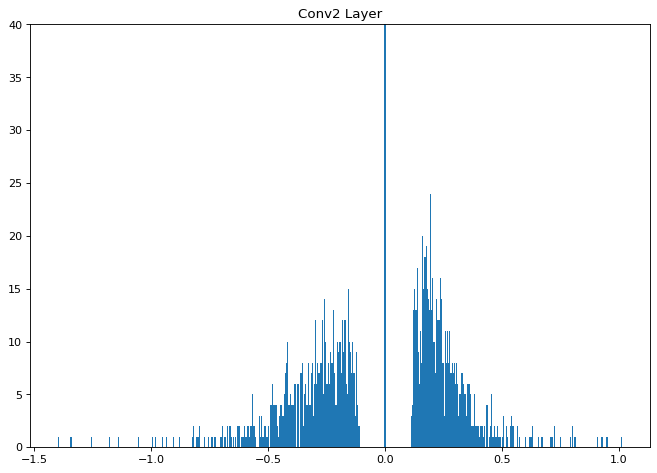

In [45]:
for layer in model.layers:
  if layer.name == "conv2":
    a = tf.reshape(layer.weights[0],[-1])
    #print(a.shape)
    figure(figsize=(10, 7), dpi=80)
    plt.title('Conv2 Layer')
    plt.hist(a,500)
    plt.show()

    print("\n")
    figure(figsize=(10, 7), dpi=80)
    plt.title('Conv2 Layer')
    plt.hist(a,500)
    plt.ylim((0,40))
    plt.show()

In [47]:
#salvar status
np.savetxt("acc_train125.csv",model_train_acc,delimiter=",")
np.savetxt("loss_train125.csv",model_train_loss,delimiter=",")
np.savetxt("sparsity125.csv",model_sparsity,delimiter=",")
np.savetxt("acc_test-125.csv",model_test_acc,delimiter=",")
np.savetxt("loss_test-125.csv",model_test_loss,delimiter=",")

In [50]:
#salvar modelo
!mkdir -p saved_model
model.save('model125/model25')
!zip -r models125.zip model125/

INFO:tensorflow:Assets written to: model125/model25/assets
  adding: model125/ (stored 0%)
  adding: model125/model25/ (stored 0%)
  adding: model125/model25/saved_model.pb (deflated 90%)
  adding: model125/model25/variables/ (stored 0%)
  adding: model125/model25/variables/variables.index (deflated 58%)
  adding: model125/model25/variables/variables.data-00000-of-00001 (deflated 45%)
  adding: model125/model25/assets/ (stored 0%)
  adding: model125/model25/keras_metadata.pb (deflated 93%)
